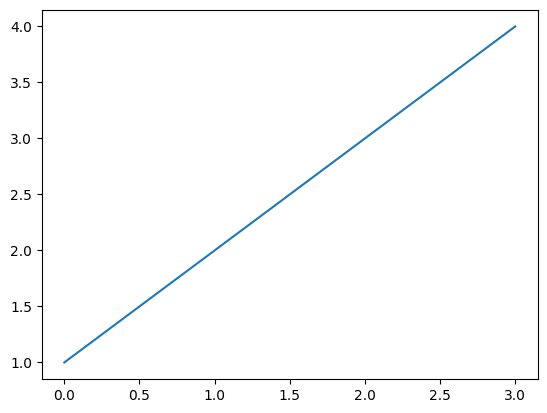

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([1,2,3,4])

In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.distributions.bernoulli import Bernoulli
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

In [3]:
batch_size = 64
train_loader = DataLoader(datasets.MNIST('./data',
                                        train=True,
                                        download=True,
                                        transform = transforms.ToTensor()),
                          batch_size=batch_size)

In [4]:
test_loader = DataLoader(datasets.MNIST('./data',
                                        train=False,
                                        transform = transforms.ToTensor()),
                        batch_size=batch_size)

In [5]:
class RBM_Pytorch(nn.Module):
    def __init__(self,n_vis = 784,
                n_hid = 100,k=1):
        super().__init__()
        self.W = nn.Parameter(torch.randn(n_hid,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))
        self.k = k
        
    def sample_from_p(self,p):
        return Bernoulli(p).sample()
    
    def h_given_v(self,v):
        
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        
        h_sample = self.sample_from_p(p_h)
        
        return p_h,h_sample
    
    def v_given_h(self,h):
        
        p_v = F.sigmoid(F.linear(h,self.W.T,self.v_bias))
        
        v_sample = self.sample_from_p(p_v)
        
        return p_v,v_sample
    
    def forward(self,v):
        
        v = v.reshape(-1,1,784)
        p_h1, h1 = self.h_given_v(v)
        h_ = h1
        
        for _ in range(self.k):
            p_v, v_ = self.v_given_h(h_)
            p_h, h_ = self.h_given_v(v_)
            
        return v, v_
    
    def free_energy(self,v):
        vbias_term = v@self.v_bias
        
        hidden_term = torch.log((v@self.W.T + self.h_bias).exp() + 1).sum(dim=2)
        return (-hidden_term - vbias_term).mean()
        
        
 
    

In [6]:
rbm = RBM_Pytorch(k=3)

In [7]:
optimizer = optim.SGD(rbm.parameters(),0.1)

In [8]:
for epoch in range(10):
    loss_ = []
    for data,target in train_loader:
        
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        
        loss_.append(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))   

Training loss for 0 epoch: -17.000033557542096
Training loss for 1 epoch: -10.946584852011219
Training loss for 2 epoch: -9.060514763220032
Training loss for 3 epoch: -7.999107686187158
Training loss for 4 epoch: -6.9971207087990575
Training loss for 5 epoch: -6.015251794095232
Training loss for 6 epoch: -4.954600059655684
Training loss for 7 epoch: -4.307427217202909
Training loss for 8 epoch: -3.7512237613897588
Training loss for 9 epoch: -3.267017226229344


In [ ]:
plt.plot(loss_)

In [9]:
def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

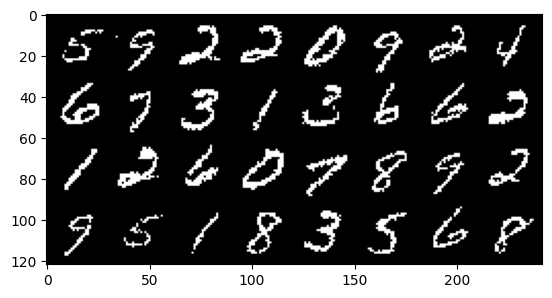

In [10]:
show_and_save("real",make_grid(v.view(32,1,28,28).data))

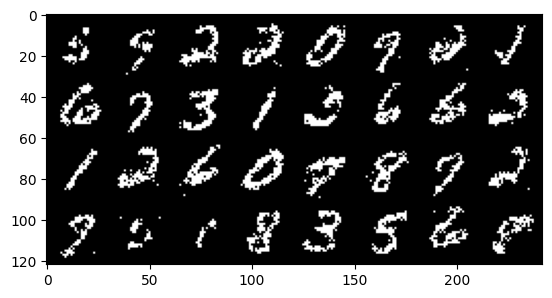

In [11]:
show_and_save("generate",make_grid(v1.view(32,1,28,28).data))